In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By # Importa By para localizar elementos
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import time
import os

# --- 1. Configuração do Driver ---
# Define o caminho para o seu ChromeDriver. AJUSTE ESTA LINHA!
# Exemplo para Windows: CHROME_DRIVER_PATH = 'drivers/chromedriver.exe'
# Exemplo para macOS/Linux: CHROME_DRIVER_PATH = 'drivers/chromedriver'
CHROME_DRIVER_PATH = 'drivers/chromedriver.exe' # <--- ALtere para o seu caminho correto!

# URL da página do IMDb que vamos raspar (Filmes Mais Populares)
IMDB_URL = "https://www.imdb.com/chart/moviemeter/"

# Listas para armazenar os dados coletados
titulos = []
anos = []
avaliacoes = []

print("Iniciando o Web Scraper do IMDb...")

try:
    # Cria um objeto Service para passar o caminho do ChromeDriver
    service = Service(executable_path=CHROME_DRIVER_PATH)

    # Inicia o navegador Chrome
    driver = webdriver.Chrome(service=service)
    print("Navegador Chrome iniciado.")

    # Define um tempo de espera implícito para o driver.
    # Isso significa que o driver vai esperar por um certo tempo
    # antes de lançar uma exceção de "elemento não encontrado".
    driver.implicitly_wait(10) # Espera até 10 segundos para elementos aparecerem

    # --- 2. Acessar a URL ---
    driver.get(IMDB_URL)
    print(f"Acessando a URL: {IMDB_URL}")
    time.sleep(3) # Pausa para garantir que a página carregou completamente

    # --- 3. Localizar e Extrair Elementos ---
    # Vamos inspecionar a página para encontrar os seletores corretos.
    # No IMDb Most Popular, os filmes estão dentro de uma tabela.
    # Cada linha da tabela representa um filme.

    # Encontrar todas as linhas de filme na tabela principal
    # A classe 'ipc-metadata-list-summary-item__tc' é usada para cada item da lista (filme)
    movie_items = driver.find_elements(By.CLASS_NAME, 'ipc-metadata-list-summary-item__tc')

    print(f"Encontrados {len(movie_items)} filmes na página.")

    for movie in movie_items:
        try:
            # Título do Filme: geralmente dentro de um <h3> com uma classe específica
            # Tente encontrar o elemento <h3> dentro de cada 'movie' item
            title_element = movie.find_element(By.CLASS_NAME, 'ipc-title__text')
            title = title_element.text.split('.', 1)[-1].strip() # Remove o número da lista (ex: "1. Título" -> "Título")
            
            # Ano de Lançamento: está dentro de um <ul> com elementos <li>
            # Localize o span que contém o ano. Pode variar, inspecione bem!
            # Para o "Most Popular Movies", o ano está dentro de um span com a classe 'sc-b069fe27-8' 
            year_element = movie.find_element(By.CLASS_NAME, 'sc-86fea7d1-8') #Ao analisar o HTML identifiquei que o elemento sc-b069fe27-8 foi trocado por sc-86fea7d1-8
            year = year_element.text.strip() # Remove espaços em branco
            
            # --- AVALIAÇÃO CORRIGIDA ---
            # O novo seletor para a avaliação, baseado no seu trecho HTML
            # Procura pelo span que contém o valor numérico da avaliação
            rating_element = movie.find_element(By.CLASS_NAME, 'ipc-rating-star--rating')
            rating_text = rating_element.text.strip() # Pega apenas o número da avaliação

            titulos.append(title)
            anos.append(year)
            avaliacoes.append(rating_text)
            
            print(f"Coletado: Título: '{title}', Ano: '{year}', Avaliação: '{rating_text}'")

        except NoSuchElementException as e:
            print(f"Erro ao encontrar um elemento para um filme (pode ser algum elemento ausente): {e}")
            # Se algum elemento não for encontrado para um filme específico,
            # podemos pular para o próximo ou registrar como 'N/A'
            titulos.append('N/A')
            anos.append('N/A')
            avaliacoes.append('N/A')
        except Exception as e:
            print(f"Ocorreu um erro inesperado ao processar um filme: {e}")
            titulos.append('N/A')
            anos.append('N/A')
            avaliacoes.append('N/A')


except TimeoutException:
    print("Tempo limite excedido. A página pode não ter carregado a tempo.")
except Exception as e:
    print(f"Ocorreu um erro ao iniciar ou processar o scraping: {e}")

finally:
    # --- 4. Fechar o Navegador ---
    if 'driver' in locals() and driver: # Garante que o driver foi inicializado antes de tentar fechar
        driver.quit()
        print("Navegador Chrome fechado.")

# Exibir os dados coletados (para verificação inicial)
print("\n--- Dados Coletados ---")
for i in range(len(titulos)):
    print(f"Título: {titulos[i]}, Ano: {anos[i]}, Avaliação: {avaliacoes[i]}")

print(f"\nTotal de filmes coletados: {len(titulos)}")

# No próximo passo, vamos transformar isso em um DataFrame Pandas!

Iniciando o Web Scraper do IMDb...
Navegador Chrome iniciado.
Acessando a URL: https://www.imdb.com/chart/moviemeter/
Encontrados 100 filmes na página.
Coletado: Título: 'F1: O Filme', Ano: '2025', Avaliação: '7,9'
Coletado: Título: 'Extermínio: A Evolução', Ano: '2025', Avaliação: '7,2'
Coletado: Título: 'Guerreiras do K-Pop', Ano: '2025', Avaliação: '7,8'
Coletado: Título: 'Como Treinar o Seu Dragão', Ano: '2025', Avaliação: '8,1'
Coletado: Título: 'Extermínio', Ano: '2002', Avaliação: '7,5'
Coletado: Título: 'Extermínio 2', Ano: '2007', Avaliação: '6,9'
Coletado: Título: '0', Ano: '2025', Avaliação: '6,3'
Erro ao encontrar um elemento para um filme (pode ser algum elemento ausente): Message: no such element: Unable to locate element: {"method":"css selector","selector":".ipc-rating-star--rating"}
  (Session info: chrome=138.0.7204.51); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktr

In [16]:
print("\n--- Iniciando Organização e Limpeza de Dados ---")
import pandas as pd
import numpy as np

# ATENÇÃO: Adicionei .copy() aqui para evitar o SettingWithCopyWarning
df_filmes_limpo = df_filmes[~(
    (df_filmes['Titulo'] == 'N/A') |
    (df_filmes['Ano'] == 'N/A') |
    (df_filmes['Avaliacao'] == 'N/A')
)].copy()

print(f"\nDataFrame após remover entradas 'N/A'. Filmes removidos: {len(df_filmes) - len(df_filmes_limpo)}")
print(df_filmes_limpo.head())

df_filmes_limpo['Avaliacao'] = df_filmes_limpo['Avaliacao'].str.replace(',', '.', regex=False)

df_filmes_limpo.loc[:, 'Ano'] = pd.to_numeric(df_filmes_limpo['Ano'], errors='coerce')
df_filmes_limpo.loc[:, 'Avaliacao'] = pd.to_numeric(df_filmes_limpo['Avaliacao'], errors='coerce')


df_filmes_limpo.dropna(inplace=True)

df_filmes_limpo.loc[:, 'Ano'] = df_filmes_limpo['Ano'].astype(int)

print("\nDataFrame após conversão de tipos e remoção de NaNs:")
print(df_filmes_limpo.info())
print(df_filmes_limpo.describe())

print("\nDados organizados e limpos com sucesso!")
print(df_filmes_limpo.head())
# Você pode salvar o DataFrame para uso futuro, se quiser
# df_filmes_limpo.to_csv('filmes_imdb_limpo.csv', index=False, encoding='utf-8')
# print("\nDados salvos em 'filmes_imdb_limpo.csv'")


--- Iniciando Organização e Limpeza de Dados ---

DataFrame após remover entradas 'N/A'. Filmes removidos: 9
                      Titulo   Ano Avaliacao
0                F1: O Filme  2025       7,9
1     Extermínio: A Evolução  2025       7,2
2        Guerreiras do K-Pop  2025       7,8
3  Como Treinar o Seu Dragão  2025       8,1
4                 Extermínio  2002       7,5

DataFrame após conversão de tipos e remoção de NaNs:
<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Titulo     91 non-null     object
 1   Ano        91 non-null     object
 2   Avaliacao  91 non-null     object
dtypes: object(3)
memory usage: 2.8+ KB
None
                           Titulo   Ano  Avaliacao
count                          91    91       91.0
unique                         90    22       36.0
top     Como Treinar o Seu Dragão  2025        6.5
freq                     


--- Iniciando Análise Exploratória de Dados e Visualização ---

Estatísticas Detalhadas das Avaliações:
count     91.0
unique    36.0
top        6.5
freq       6.0
Name: Avaliacao, dtype: float64


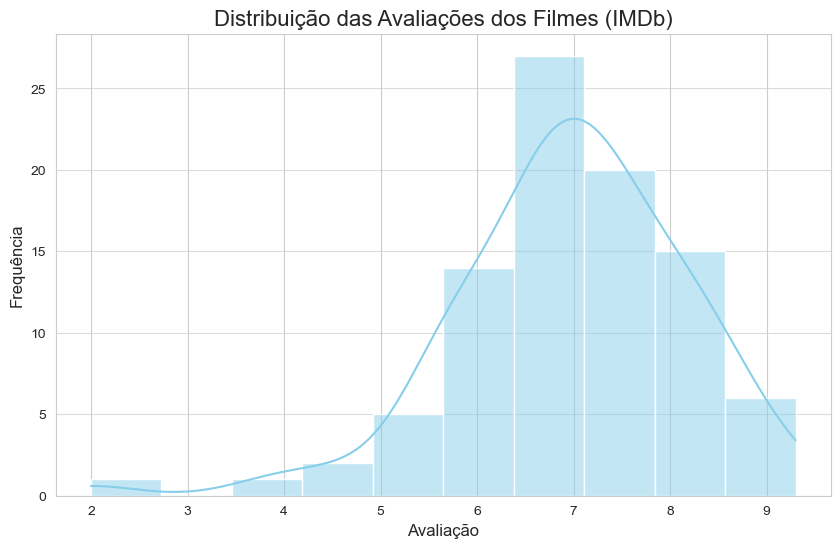


Contagem de Filmes por Ano:
Ano
1965     1
1972     1
1975     1
1987     1
1993     1
1994     1
1995     1
1999     1
2000     1
2001     1
2002     1
2007     2
2010     2
2014     1
2015     1
2016     2
2019     2
2020     1
2022     3
2023     3
2024    12
2025    51
Name: count, dtype: int64


C:\Users\gusta\AppData\Local\Temp\ipykernel_10696\1374660143.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filmes_por_ano.index, y=filmes_por_ano.values, palette='viridis')


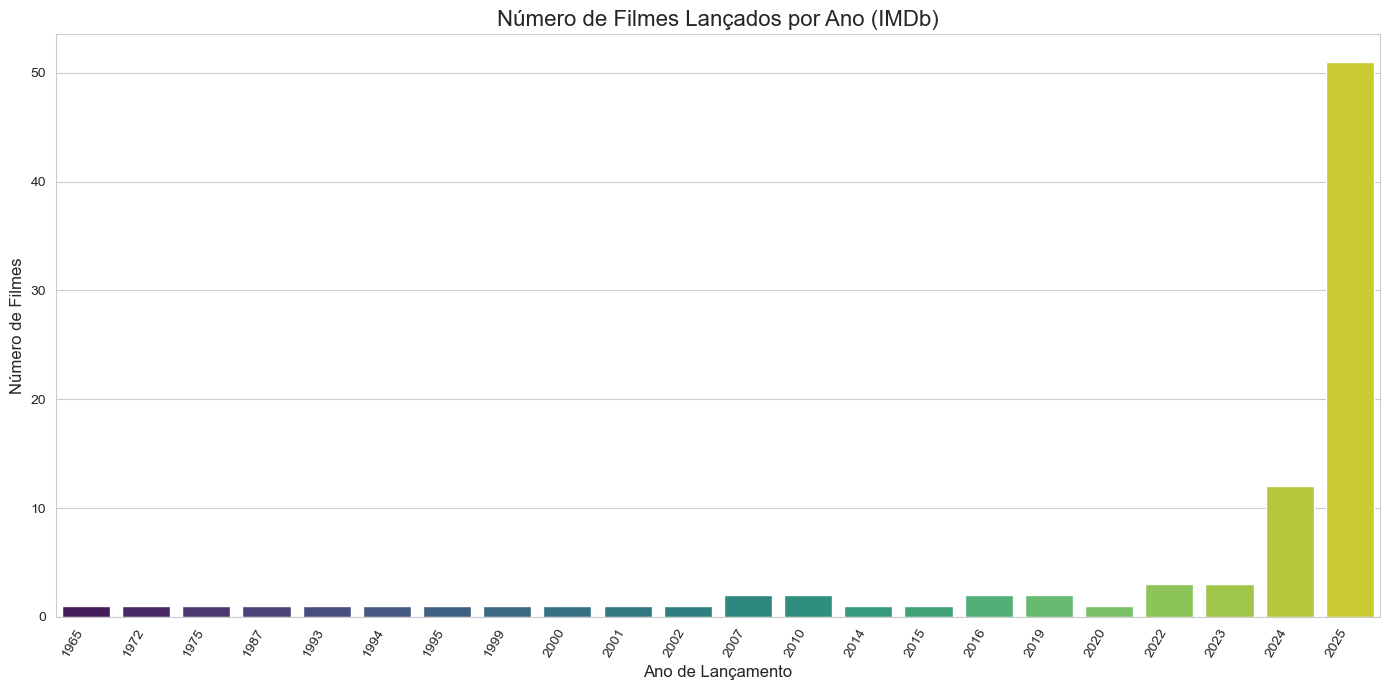


Avaliação Média por Ano de Lançamento:
    Ano Avaliacao
0  1965       3.8
1  1972       9.2
2  1975       8.1
3  1987       7.1
4  1993       8.2


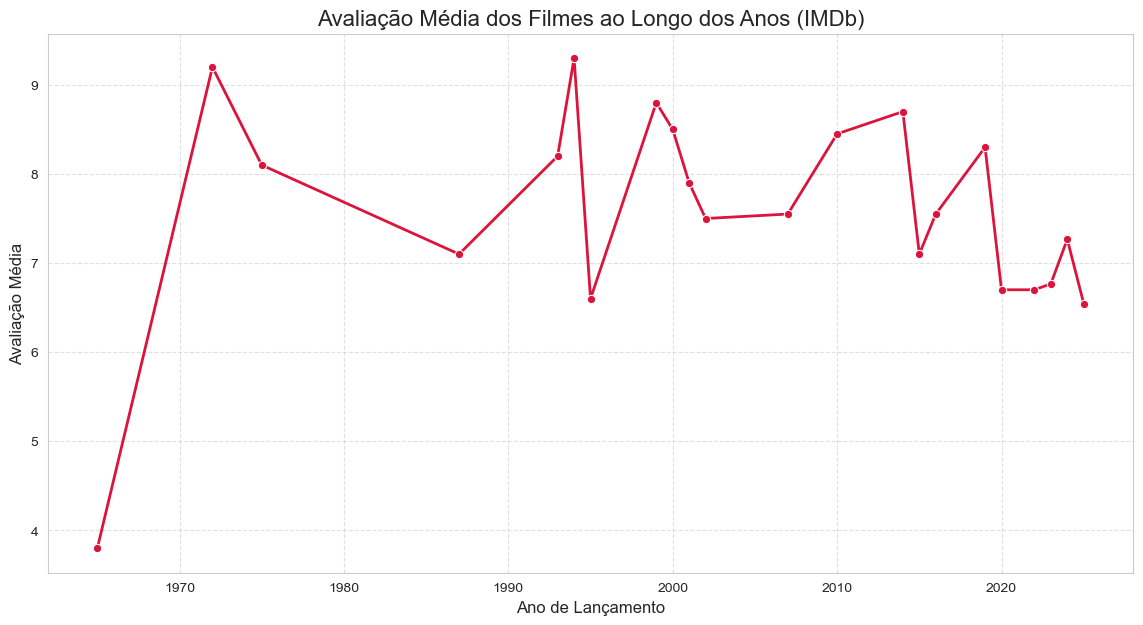

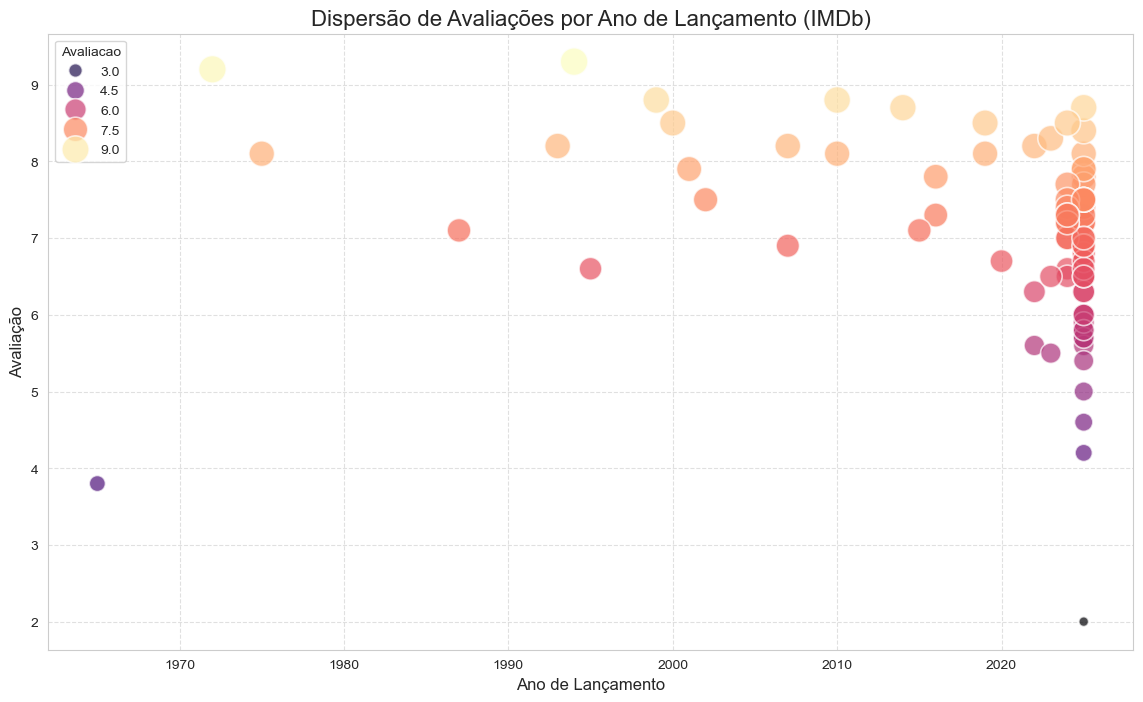


Análise Exploratória de Dados e Visualização concluídas!


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Iniciando Análise Exploratória de Dados e Visualização ---")

# Configuração estética dos gráficos com Seaborn
sns.set_style("whitegrid")
sns.set_palette("deep")

print("\nEstatísticas Detalhadas das Avaliações:")
print(df_filmes_limpo['Avaliacao'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_filmes_limpo['Avaliacao'], kde=True, bins=10, color='skyblue')
plt.title('Distribuição das Avaliações dos Filmes (IMDb)', fontsize=16)
plt.xlabel('Avaliação', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.7)
plt.show()


# Conta quantos filmes foram lançados em cada ano
filmes_por_ano = df_filmes_limpo['Ano'].value_counts().sort_index()

print("\nContagem de Filmes por Ano:")
print(filmes_por_ano)

plt.figure(figsize=(14, 7))
sns.barplot(x=filmes_por_ano.index, y=filmes_por_ano.values, palette='viridis')
plt.title('Número de Filmes Lançados por Ano (IMDb)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Número de Filmes', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10) # Rotação maior para anos
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 5.3. Avaliação Média por Ano de Lançamento (Tendência)
# Agrupa os dados por ano e calcula a avaliação média para cada ano
avaliacao_media_por_ano = df_filmes_limpo.groupby('Ano')['Avaliacao'].mean().reset_index()

print("\nAvaliação Média por Ano de Lançamento:")
print(avaliacao_media_por_ano.head())

plt.figure(figsize=(14, 7))
sns.lineplot(x='Ano', y='Avaliacao', data=avaliacao_media_por_ano, marker='o', color='crimson', linewidth=2)
plt.title('Avaliação Média dos Filmes ao Longo dos Anos (IMDb)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Avaliação Média', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5.4. Relação entre Ano e Avaliação Individual (Dispersão)
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Ano', y='Avaliacao', data=df_filmes_limpo,
                alpha=0.7, # Transparência dos pontos
                hue='Avaliacao', # Colore os pontos com base na avaliação
                size='Avaliacao', # Ajusta o tamanho dos pontos pela avaliação
                sizes=(50, 400), # Intervalo de tamanho dos pontos
                palette='magma') # Paleta de cores para o calor das avaliações
plt.title('Dispersão de Avaliações por Ano de Lançamento (IMDb)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Avaliação', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nAnálise Exploratória de Dados e Visualização concluídas!")

# Opcional: Salvar o DataFrame final para uso posterior
# df_filmes_limpo.to_csv('filmes_imdb_analise.csv', index=False, encoding='utf-8')
# print("\nDados finais salvos em 'filmes_imdb_analise.csv'")